# Baseline Model

**Table of Contents**
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


### Model Choice
A Convolutional Neural Network (CNN) is an ideal baseline model for classifying 50 types of phytoplankton images, as it excels in capturing the subtle variances in shape, size, and texture that are crucial for distinguishing between different phytoplankton types. With its robustness to image variations and effectiveness in complex multi-class tasks, a CNN is highly suitable for this purpose. Moreover, its scalability and the potential for transfer learning add to its practicality in handling diverse datasets. Importantly, a CNN serves as an excellent starting point for model optimization, where further improvements can be achieved by fine-tuning hyperparameters and experimenting with various preprocessing techniques, allowing for tailored enhancements to suit specific dataset characteristics.

In [1]:
# This Notebook is meant to run on a google colab notebook, where the dataset is mounted in the linked google drive.

# import libraries
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/Phytoplankton_true/labeled_20201020"

# Split the Data into train, validation, and test sets; get all image paths and their corresponding labels
image_paths = []
labels = []
for class_dir in os.listdir(data_dir):
    class_dir_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_dir_path):
        for image in os.listdir(class_dir_path):
            image_paths.append(os.path.join(class_dir_path, image))
            labels.append(class_dir)

# Convert labels to numerical format
labels = np.array(labels)
label_to_index = dict((name, index) for index, name in enumerate(np.unique(labels)))
labels = np.array([label_to_index[label] for label in labels])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=42)

Mounted at /content/drive


### Feature Selection

In the context of using a Convolutional Neural Network (CNN) for classifying images of phytoplankton, "feature selection" takes on a different meaning compared to traditional machine learning models. Unlike models where you manually select features from a dataset, CNNs handle feature extraction and selection internally through their layers.

Training Data Examples:
Example 1:
Image batch shape: (64, 128, 128, 3)
Label batch shape: (64, 50)


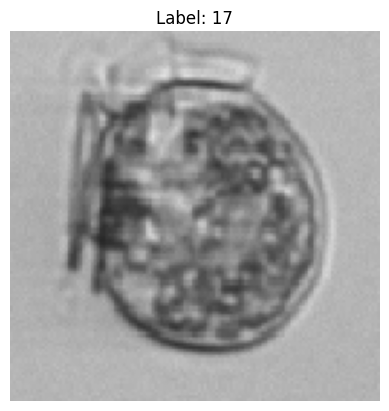

In [7]:
# Data Preprocessing and Augmentation setup
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data in Batches
def data_generator(image_paths, labels, batch_size, datagen):
    while True:
        for start in range(0, len(image_paths), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(image_paths))
            for img_path, label in zip(image_paths[start:end], labels[start:end]):
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
                img = tf.keras.preprocessing.image.img_to_array(img)
                x_batch.append(img)
                y_batch.append(label)
            x_batch = np.array(x_batch)
            y_batch = tf.keras.utils.to_categorical(y_batch, num_classes=50)
            yield datagen.flow(x_batch, y_batch, batch_size=batch_size).next()

# Define batch size
batch_size = 64

# Create data generators
train_generator = data_generator(X_train, y_train, batch_size, train_datagen)
val_generator = data_generator(X_val, y_val, batch_size, val_datagen)
test_generator = data_generator(X_test, y_test, batch_size, test_datagen)

# Function to print data format and display images
def print_and_display_data_examples(generator, num_examples=1, num_images=1):
    for i in range(num_examples):
        # Get the next batch of images and labels
        x_batch, y_batch = next(generator)
        print(f'Example {i+1}:')
        print(f'Image batch shape: {x_batch.shape}')
        print(f'Label batch shape: {y_batch.shape}')

        # Display the first 'num_images' images in the batch
        for j in range(num_images):
            plt.imshow(x_batch[j])
            plt.title(f'Label: {np.argmax(y_batch[j])}')
            plt.axis('off')  # Hide the axis
            plt.show()  # Show one image at a time

# Print and display examples from the training data generator
print('Training Data Examples:')
print_and_display_data_examples(train_generator)

### Implementation

This CNN model, with its multiple convolutional and pooling layers followed by fully connected layers, is designed to effectively capture the hierarchical features in the phytoplankton images, making it suitable for the classification task at hand. The use of ReLU and softmax activations, along with the adam optimizer and categorical crossentropy loss, aligns well with the needs of a complex image classification challenge.

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(128, 128, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(96, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(32),
    Activation('relu'),
    Dense(50),
    Activation('softmax')
])

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 activation_7 (Activation)   (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 128)       36992     
                                                                 
 activation_8 (Activation)   (None, 61, 61, 128)       0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                 

In [9]:
# Set your training parameters
epochs = 10  # Number of epochs to train for

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,  # Number of steps per epoch
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size   # Number of validation steps
)


Epoch 1/10
115/115 [==============================] - 1876s 16s/step - loss: 3.5054 - accuracy: 0.2208 - val_loss: 3.3026 - val_accuracy: 0.2554
Epoch 2/10
115/115 [==============================] - 361s 3s/step - loss: 3.2930 - accuracy: 0.2379 - val_loss: 2.9339 - val_accuracy: 0.3042
Epoch 3/10
115/115 [==============================] - 363s 3s/step - loss: 2.7890 - accuracy: 0.3090 - val_loss: 2.3228 - val_accuracy: 0.4105
Epoch 4/10
115/115 [==============================] - 347s 3s/step - loss: 2.2832 - accuracy: 0.4008 - val_loss: 1.8993 - val_accuracy: 0.4933
Epoch 5/10
115/115 [==============================] - 363s 3s/step - loss: 1.9281 - accuracy: 0.4686 - val_loss: 1.6413 - val_accuracy: 0.5500
Epoch 6/10
115/115 [==============================] - 375s 3s/step - loss: 1.6756 - accuracy: 0.5250 - val_loss: 1.4467 - val_accuracy: 0.5919
Epoch 7/10
115/115 [==============================] - 360s 3s/step - loss: 1.4804 - accuracy: 0.5716 - val_loss: 1.3458 - val_accuracy: 0.62

### Evaluation

1. Accuracy: This metric gives you a straightforward indication of the overall correctness of the model by showing the proportion of correct predictions out of all predictions. It's a useful initial indicator to see how well the model performs across all classes.

2. Confusion Matrix: This tool is particularly valuable in multi-class classification problems like your 50 phytoplankton types. It not only shows the overall performance but also breaks it down into each class, revealing how the model confuses between different types of phytoplankton. It can highlight if the model is particularly good or bad at classifying certain classes, which is critical information for fine-tuning.

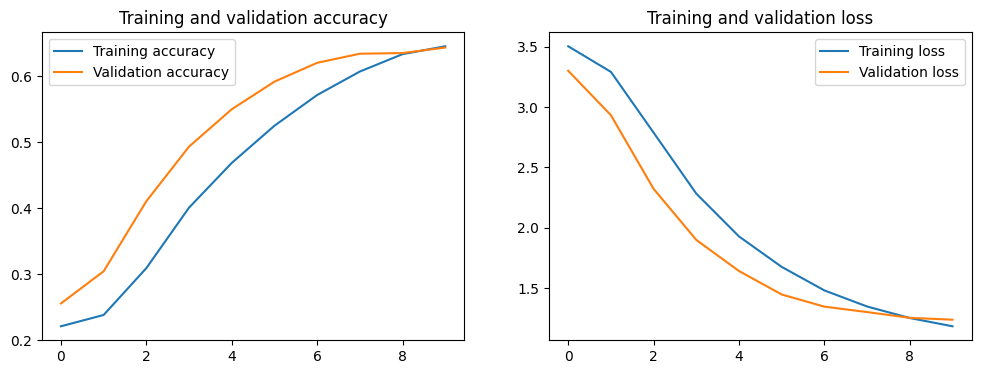

In [10]:
# Generate plots for data visualization
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)

1/1 [==============================] - 0s 190ms/step


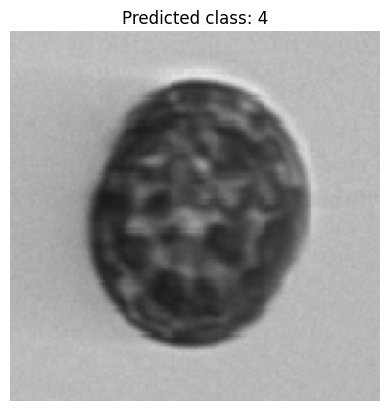

4

In [11]:
from tensorflow.keras.preprocessing import image

# Function to load, preprocess, and predict a single image
def predict_single_image(img_path, model):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale the image

    # Make a prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f'Predicted class: {predicted_class}')
    plt.axis('off')  # Hide the axis
    plt.show()

    return predicted_class

img_path = '/content/drive/MyDrive/Phytoplankton_true/labeled_20201020/Centrales_sp/Centrales_sp.101.png'
predict_single_image(img_path, model)


17/17 [==============================] - 377s 24s/step


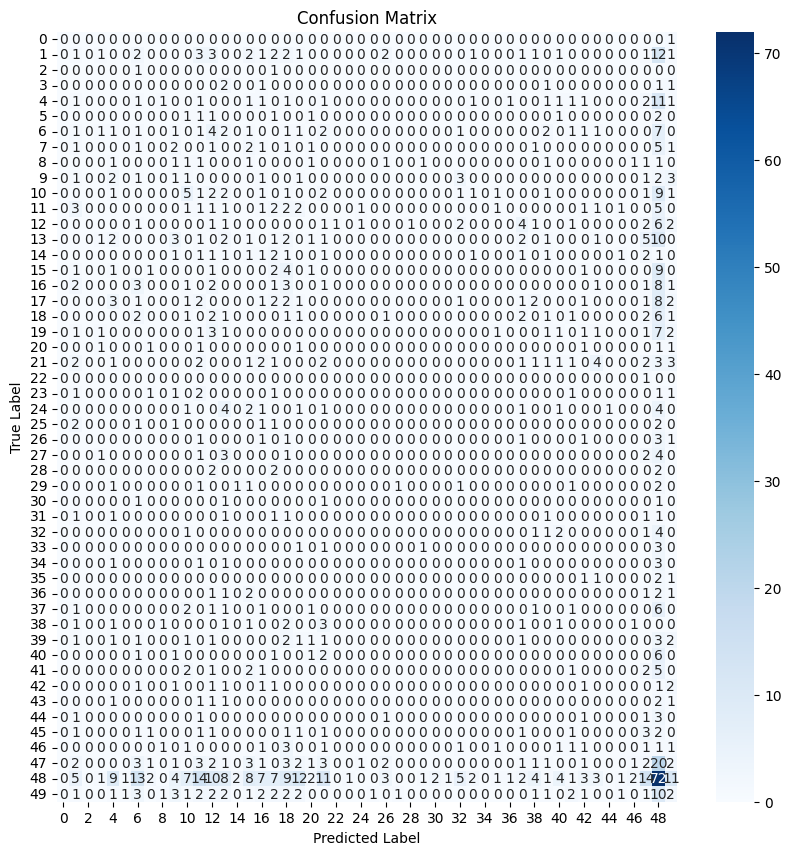

In [12]:
# Assuming the model has been trained and test_generator has been created correctly
# Predict the labels for the test set
predictions = model.predict(test_generator, steps=np.math.ceil(len(X_test)/batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# Assuming that y_test contains the true labels in the correct order corresponding to X_test
# and that it is a 1D array with the class indices as integers
true_classes = y_test

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [13]:
# Assuming 'cm' is your confusion matrix
correct_predictions = np.trace(cm)  # Sum of diagonal elements
total_predictions = np.sum(cm)      # Sum of all elements

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.09
